<a href="https://colab.research.google.com/github/SoniHarsh1/Dynamic-Allocation-Strategies-for-Multi-Agent-Target-Defense-Differential-Games/blob/main/2v2v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Attacker - Defender Assignment
[[1 0]
 [0 1]]
time - 0
Attacker - Target Assignment
[[1 0]
 [0 1]]
time - 0


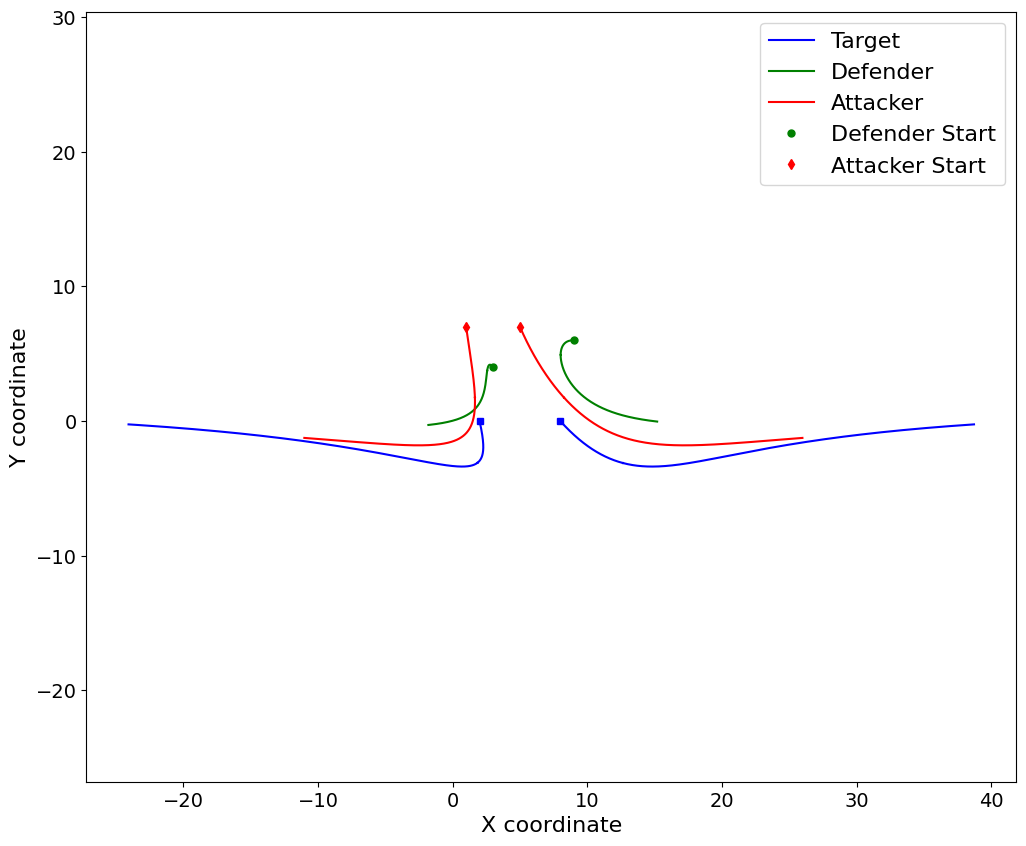

Game ended without capture
Game duration: 0.12 time units


In [ ]:
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
from scipy.linalg import expm, inv
from scipy.optimize import linear_sum_assignment
!pip install pulp
from pulp import *

import matplotlib.animation as animation
from matplotlib.patches import Circle
from IPython.display import HTML
import os

# Initial location of the players (2 target, 2 defenders, 2 attackers)

# X_0 = np.array([
#     3, 0,    # Target 1 at (1,1)
#     6, 0,    # Target 2 at (4,1)
#     3, 3,    # Defender 1 at (0,3)
#     5, 3,    # Defender 2 at (5,3)
#     2, 7,    # Attacker 1 at (2,4)
#     8, 7     # Attacker 2 at (3,4)
# ], dtype=float)


# # Configuration 1: Defenders between Targets and Attackers
# X_0 = np.array([
#     3, 0,    # Target 1
#     6, 0,    # Target 2
#     3, 3,    # Defender 1
#     6, 3,    # Defender 2
#     2, 7,    # Attacker 1
#     7, 7     # Attacker 2
# ], dtype=float)

# # Configuration 2: Attackers flanking from sides
# X_0_2 = np.array([
#     4, 2,    # Target 1
#     6, 2,    # Target 2
#     4, 4,    # Defender 1
#     6, 4,    # Defender 2
#     0, 3,    # Attacker 1
#     10, 3    # Attacker 2
# ], dtype=float)

# # Configuration 3: Diagonal formation
# X_0_3 = np.array([
#     1, 1,    # Target 1
#     2, 2,    # Target 2
#     4, 4,    # Defender 1
#     5, 5,    # Defender 2
#     7, 7,    # Attacker 1
#     8, 8     # Attacker 2
# ], dtype=float)

# # Configuration 4: Circular formation
# X_0_4 = np.array([
#     5, 0,    # Target 1
#     5, 2,    # Target 2
#     3, 5,    # Defender 1
#     7, 5,    # Defender 2
#     5, 8,    # Attacker 1
#     5, 10    # Attacker 2
# ], dtype=float)

# # Configuration 5: Attackers with height advantage
# X_0_5 = np.array([
#     2, 0,    # Target 1
#     8, 0,    # Target 2
#     2, 2,    # Defender 1
#     8, 2,    # Defender 2
#     5, 8,    # Attacker 1
#     5, 9     # Attacker 2
# ], dtype=float)

# # Configuration 6: Targets separated widely
# X_0_6 = np.array([
#     0, 0,    # Target 1
#     10, 0,   # Target 2
#     3, 3,    # Defender 1
#     7, 3,    # Defender 2
#     5, 5,    # Attacker 1
#     5, 6     # Attacker 2
# ], dtype=float)

# # Configuration 7: Compact formation
# X_0_7 = np.array([
#     4, 1,    # Target 1
#     6, 1,    # Target 2
#     4, 2,    # Defender 1
#     6, 2,    # Defender 2
#     4, 4,    # Attacker 1
#     6, 4     # Attacker 2
# ], dtype=float)

# # Configuration 8: Asymmetric formation
# X_0_8 = np.array([
#     2, 1,    # Target 1
#     8, 3,    # Target 2
#     3, 4,    # Defender 1
#     7, 5,    # Defender 2
#     1, 8,    # Attacker 1
#     9, 7     # Attacker 2
# ], dtype=float)

# # Configuration 9: Box formation
# X_0_9 = np.array([
#     3, 1,    # Target 1
#     7, 1,    # Target 2
#     3, 5,    # Defender 1
#     7, 5,    # Defender 2
#     3, 9,    # Attacker 1
#     7, 9     # Attacker 2
# ], dtype=float)

# # Configuration 10: Mixed distances
# X_0_10 = np.array([
#     2, 2,    # Target 1
#     8, 1,    # Target 2
#     4, 4,    # Defender 1
#     6, 3,    # Defender 2
#     3, 7,    # Attacker 1
#     7, 6     # Attacker 2
# ], dtype=float)

# #Take 1
# X_0 = np.array([
#     3, 0,    # Target 1
#     6, 0,    # Target 2
#     0, 1,    # Defender 1
#     7, 1,    # Defender 2
#     2, 7,    # Attacker 1
#     7, 7     # Attacker 2
# ], dtype=float)

#Take 2
X_0 = np.array([
    2, 0,    # Target 1: positioned at bottom left
    8, 0,    # Target 2: positioned at bottom right
    3, 4,    # Defender 1: positioned to protect left target
    9, 6,    # Defender 2: positioned too far right and high
    1, 7,    # Attacker 1: starting far left
    5, 7     # Attacker 2: starting center-right
], dtype=float)

# Initialization parameters
O_12 = np.zeros((12, 12))
O = np.zeros((2, 2))
I = np.eye(12)

B_t1 = np.vstack((np.eye(2), np.zeros((10, 2))))
B_t2 = np.vstack((np.zeros((2, 2)), np.eye(2), np.zeros((8, 2))))
B_d1 = np.vstack((np.zeros((4, 2)), np.eye(2), np.zeros((6, 2))))
B_d2 = np.vstack((np.zeros((6, 2)), np.eye(2), np.zeros((4, 2))))
B_a1 = np.vstack((np.zeros((8, 2)), np.eye(2), np.zeros((2, 2))))
B_a2 = np.vstack((np.zeros((10, 2)), np.eye(2)))

rt1, rt2, rd1, rd2, ra1, ra2 = 30, 30, 20, 20, 20, 20
R_t1 = rt1 * np.eye(2)
R_t2 = rt2 * np.eye(2)
R_d1 = rd1 * np.eye(2)
R_d2 = rd2 * np.eye(2)
R_a1 = ra1 * np.eye(2)
R_a2 = ra2 * np.eye(2)

# Basic Q matrices for interactions
Q_a1d1T = Q_a2d2T = Q_a1d2T = Q_a2d1T = 1 * np.eye(2)  # Defender-Attacker interaction
Q_a1d1T1 = Q_a2d2T1 = Q_a1d2T1 = Q_a2d1T1 = 1 * np.eye(2)  # Attacker-Defender interaction
Q_a1t1T = Q_a2t1T = Q_a1t2T = Q_a2t2T = 2.0 * np.eye(2)  # Attacker-Target interaction
Q_d1t1T = Q_d2t1T = Q_d1t2T = Q_d2t2T = 1 * np.eye(2)  # Defender-Target interaction

S_t1 = B_t1 @ inv(R_t1) @ B_t1.T
S_t2 = B_t2 @ inv(R_t2) @ B_t2.T
S_d1 = B_d1 @ inv(R_d1) @ B_d1.T
S_d2 = B_d2 @ inv(R_d2) @ B_d2.T
S_a1 = B_a1 @ inv(R_a1) @ B_a1.T
S_a2 = B_a2 @ inv(R_a2) @ B_a2.T

# Initialize variables to store capture information
captured_by_attacker = False
capturing_attacker = None
all_attackers_captured = False
all_targets_captured = False
capturing_agent_index = None
t_capturing_agent_index = None
captured_attackers = [False, False]
captured_targets = [False, False]

def euclidean_distance(pos1, pos2):
    return np.linalg.norm(np.array(pos1) - np.array(pos2))

# Get the assignment using PuLP
def get_assignment(defenders, attackers, captured_attackers):
    num_defenders = len(defenders)
    num_attackers = len(attackers)
    active_attackers = sum(1 for a in captured_attackers if not a)

    # Create the LP problem
    prob = LpProblem("Defender-Attacker_Assignment", LpMinimize)

    # Create decision variables only for non-captured attackers
    choices = LpVariable.dicts("Choice",
                               ((i, j) for i in range(num_defenders) for j in range(num_attackers) if not captured_attackers[j]),
                               cat='Binary')

    # Objective function
    prob += lpSum([euclidean_distance(defenders[i], attackers[j]) * choices[(i, j)]
                   for i in range(num_defenders) for j in range(num_attackers) if not captured_attackers[j]])

    # Constraints
    # Each active attacker is assigned to at most one defender
    for j in range(num_attackers):
        if not captured_attackers[j]:
            prob += lpSum([choices[(i, j)] for i in range(num_defenders)]) <= 1

    # Each defender is assigned to at most one attacker
    for i in range(num_defenders):
        prob += lpSum([choices[(i, j)] for j in range(num_attackers) if not captured_attackers[j]]) <= 1

    # Total assignments should be the minimum of active attackers and defenders
    prob += lpSum([choices[(i, j)] for i in range(num_defenders)
                   for j in range(num_attackers) if not captured_attackers[j]]) == min(num_defenders, active_attackers)

    # Solve the problem
    prob.solve()

    # Create the assignment matrix (maintaining original dimensions)
    assignment_matrix = np.zeros((num_defenders, num_attackers), dtype=int)
    for i in range(num_defenders):
        for j in range(num_attackers):
            if not captured_attackers[j] and (i, j) in choices:
                if choices[(i, j)].value() == 1:
                    assignment_matrix[i][j] = 1

    return assignment_matrix


# Defender - Attackers Assignment with target cost consideration
# def get_assignment(defenders, attackers, captured_attackers, target_cost):
#     num_defenders = len(defenders)
#     num_attackers = len(attackers)
#     active_attackers = sum(1 for a in captured_attackers if not a)

#     # Create the LP problem
#     prob = LpProblem("Defender-Attacker_Assignment", LpMinimize)

#     # Create decision variables only for non-captured attackers
#     choices = LpVariable.dicts("Choice",
#                                ((i, j) for i in range(num_defenders) for j in range(num_attackers) if not captured_attackers[j]),
#                                cat='Binary')

#     # Objective function
#     prob += lpSum([euclidean_distance(defenders[i], attackers[j]) * choices[(i, j)]
#                    for i in range(num_defenders) for j in range(num_attackers) if not captured_attackers[j]])

#     # Constraints
#     # Each active attacker is assigned to at most one defender
#     for j in range(num_attackers):
#         if not captured_attackers[j]:
#             prob += lpSum([choices[(i, j)] for i in range(num_defenders)]) <= 1

#     # Each defender is assigned to at most one attacker
#     for i in range(num_defenders):
#         prob += lpSum([choices[(i, j)] for j in range(num_attackers) if not captured_attackers[j]]) <= 1

#     # Total assignments should be the minimum of active attackers and defenders
#     prob += lpSum([choices[(i, j)] for i in range(num_defenders)
#                    for j in range(num_attackers) if not captured_attackers[j]]) == min(num_defenders, active_attackers)

#     # Solve the problem
#     prob.solve()

#     # Create the assignment matrix (maintaining original dimensions)
#     assignment_matrix = np.zeros((num_defenders, num_attackers), dtype=int)
#     for i in range(num_defenders):
#         for j in range(num_attackers):
#             if not captured_attackers[j] and (i, j) in choices:
#                 if choices[(i, j)].value() == 1:
#                     assignment_matrix[i][j] = 1

#     return assignment_matrix

# Attacker - Target Assignment
def get_attackers_assignment(attackers, targets, captured_attackers, captured_targets):
    num_targets = len(targets)
    num_attackers = len(attackers)
    active_targets = sum(1 for a in captured_targets if not a)
    active_attackers = sum(1 for a in captured_attackers if not a)

    # Create the LP problem
    prob = LpProblem("Attacker-Target_Assignment", LpMinimize)

    # Create decision variables only for non-captured attackers
    choices = LpVariable.dicts("Choice",
                               ((i, j) for i in range(num_attackers) if not captured_attackers[i]
                              for j in range(num_targets) if not captured_targets[j]),
                               cat='Binary')

    # Objective function
    prob += lpSum([euclidean_distance(attackers[i], targets[j]) * choices[(i, j)]
                  for i in range(num_attackers) if not captured_attackers[i]
                  for j in range(num_targets) if not captured_targets[j]])

    # Constraints
    # Each active target is assigned to at most one attackers
    for j in range(num_targets):
        if not captured_targets[j]:
            prob += lpSum([choices[(i, j)] for i in range(num_attackers) if not captured_attackers[i]]) <= 1

    # Each defender is assigned to at most one attacker
    for i in range(num_attackers):
      if not captured_attackers[i]:
        prob += lpSum([choices[(i, j)] for j in range(num_targets) if not captured_targets[j]]) <= 1

    # Total assignments should be the minimum of active attackers and defenders
    prob += lpSum([choices[(i, j)] for i in range(num_attackers) if not captured_attackers[i]
                   for j in range(num_targets) if not captured_targets[j]]) == min(active_attackers, active_targets)

    # Solve the problem
    prob.solve()

    # Create the assignment matrix (maintaining original dimensions)
    assignment_matrix = np.zeros((num_attackers, num_targets), dtype=int)
    for i in range(num_attackers):
        for j in range(num_targets):
            if not captured_targets[j] and not captured_attackers[i] and (i, j) in choices:
                if choices[(i, j)].value() == 1:
                    assignment_matrix[i][j] = 1

    return assignment_matrix


def get_target_cost (targets, attackers, captured_targets, captured_attackers):
  num_targets = len(targets)
  num_attackers = len(attackers)
  target_cost = np.zeros((num_targets), dtype = float)
  for j in range(num_targets):
    if not captured_targets[j]:
      temp = 0.0
      for i in range(num_attackers):
        if not captured_attackers[i]:
          temp += euclidean_distance(targets[j], attackers[i])
      if temp!=0:target_cost[j] = 1/temp
      else: target_cost[j] = 0.0
    #   target_cost[j] = temp
    # else: target_cost[j] = 0.0
  return target_cost

# Step size and T selection
T = 0.02
tk = 0
step1 = 100
deltaT = T / step1
j = 0
sigmaa = 0.25
sigmad = 0.25
sigmat = 0
tflag = 0
time = [tk]
count = 0
X_t = []
a=0;    # lambda <----- Change it to vary the attacker's awareness towards defender

check = np.zeros((2, 2), dtype=int)
check_t = np.zeros((2, 2), dtype=int)


while tflag == 0:
    targets = [X_0[0:2], X_0[2:4]]
    defenders = [X_0[4:6], X_0[6:8]]
    attackers = [X_0[8:10], X_0[10:12]]

    target_cost = get_target_cost(targets, attackers, captured_targets, captured_attackers)


    #print(target_cost)
    # Get the assignment matrix
    Ada = get_assignment(defenders, attackers, captured_attackers)
    Ata = get_attackers_assignment(attackers, targets, captured_attackers, captured_targets)

    if (check != Ada).any():
        print("Attacker - Defender Assignment")
        print(Ada)
        check = Ada
        print("time -", time[-1])

    if (check_t != Ata).any():
        print("Attacker - Target Assignment")
        print(Ata)
        check_t = Ata
        print("time -", time[-1])


    # Target 1 matrix Q_t1
    Q_t1 = np.block([
        # t1   t2    d1    d2    a1    a2
        [Q_d1t1T+Q_d2t1T-Q_a1t1T-Q_a2t1T, O, -Q_d1t1T, -Q_d2t1T, Q_a1t1T, Q_a2t1T],  # t1
        [O, O, O, O, O, O],  # t2
        [-Q_d1t1T, O, Q_d1t1T, O, O, O],  # d1
        [-Q_d2t1T, O, O, Q_d2t1T, O, O],  # d2
        [Q_a1t1T, O, O, O, -Q_a1t1T, O],  # a1
        [Q_a2t1T, O, O, O, O, -Q_a2t1T]   # a2
    ])

    # Target 2 matrix Q_t2
    Q_t2 = np.block([
        # t1   t2    d1    d2    a1    a2
        [O, O, O, O, O, O],  # t1
        [O, Q_d1t2T+Q_d2t2T-Q_a1t2T-Q_a2t2T, -Q_d1t2T, -Q_d2t2T, Q_a1t2T, Q_a2t2T],  # t2
        [O, -Q_d1t2T, Q_d1t2T, O, O, O],  # d1
        [O, -Q_d2t2T, O, Q_d2t2T, O, O],  # d2
        [O, Q_a1t2T, O, O, -Q_a1t2T, O],  # a1
        [O, Q_a2t2T, O, O, O, -Q_a2t2T]   # a2
    ])

    # Defender 1 matrix Q_d1
    Q_d1 = np.block([
        # t1   t2    d1    d2    a1    a2
        [target_cost[0]*Q_d1t1T, O, -target_cost[0]*Q_d1t1T, O, O, O],  # t1
        [O, target_cost[1]*Q_d1t2T, -target_cost[1]*Q_d1t2T, O, O, O],  # t2
        [-target_cost[0]*Q_d1t1T, -target_cost[1]*Q_d1t2T, target_cost[0]*Q_d1t1T+target_cost[1]*Q_d1t2T+Ada[0][0]*Q_a1d1T+Ada[0][1]*Q_a2d1T, O, -Ada[0][0]*Q_a1d1T, -Ada[0][1]*Q_a2d1T],  # d1
        [O, O, O, O, O, O],  # d2
        [O, O, -Ada[0][0]*Q_a1d1T, O, Ada[0][0]*Q_a1d1T, O],  # a1
        [O, O, -Ada[0][1]*Q_a2d1T, O, O, Ada[0][1]*Q_a2d1T]   # a2
    ])
    # Q_d1 = np.block([
    # # t1   t2    d1    d2    a1    a2
    # [Q_d1t1T, O, -Q_d1t1T, O, O, O],  # t1
    # [O, Q_d1t2T, -Q_d1t2T, O, O, O],  # t2
    # [-Q_d1t1T, -Q_d1t2T, Q_d1t1T+Q_d1t2T+Ada[0][0]*Q_a1d1T+Ada[0][1]*Q_a2d1T, O, -Ada[0][0]*Q_a1d1T, -Ada[0][1]*Q_a2d1T],  # d1
    # [O, O, O, O, O, O],  # d2
    # [O, O, -Ada[0][0]*Q_a1d1T, O, Ada[0][0]*Q_a1d1T, O],  # a1
    # [O, O, -Ada[0][1]*Q_a2d1T, O, O, Ada[0][1]*Q_a2d1T]   # a2
    # ])

    # Defender 2 matrix Q_d2
    Q_d2 = np.block([
        # t1   t2    d1    d2    a1    a2
        [target_cost[0]*Q_d2t1T, O, O, -target_cost[0]*Q_d2t1T, O, O],  # t1
        [O, target_cost[1]*Q_d2t2T, O, -target_cost[1]*Q_d2t2T, O, O],  # t2
        [O, O, O, O, O, O],  # d1
        [-target_cost[0]*Q_d2t1T, -target_cost[1]*Q_d2t2T, O, target_cost[0]*Q_d2t1T+target_cost[1]*Q_d2t2T+Ada[1][0]*Q_a1d2T+Ada[1][1]*Q_a2d2T, -Ada[1][0]*Q_a1d2T, -Ada[1][1]*Q_a2d2T],  # d2
        [O, O, O, -Ada[1][0]*Q_a1d2T, Ada[1][0]*Q_a1d2T, O],  # a1
        [O, O, O, -Ada[1][1]*Q_a2d2T, O, Ada[1][1]*Q_a2d2T]   # a2
    ])
    # Q_d2 = np.block([
    # # t1   t2    d1    d2    a1    a2
    # [Q_d2t1T, O, O, -Q_d2t1T, O, O],  # t1
    # [O, Q_d2t2T, O, -Q_d2t2T, O, O],  # t2
    # [O, O, O, O, O, O],  # d1
    # [-Q_d2t1T, -Q_d2t2T, O, Q_d2t1T+Q_d2t2T+Ada[1][0]*Q_a1d2T+Ada[1][1]*Q_a2d2T, -Ada[1][0]*Q_a1d2T, -Ada[1][1]*Q_a2d2T],  # d2
    # [O, O, O, -Ada[1][0]*Q_a1d2T, Ada[1][0]*Q_a1d2T, O],  # a1
    # [O, O, O, -Ada[1][1]*Q_a2d2T, O, Ada[1][1]*Q_a2d2T]   # a2
    # ])

    # Attacker 1 matrix Q_a1
    Q_a1 = np.block([
        # t1   t2    d1    d2    a1    a2
        [Ata[0][0]*Q_a1t1T, O, O, O, -Ata[0][0]*Q_a1t1T, O],  # t1
        [O, Ata[0][1]*Q_a1t2T, O, O, -Ata[0][1]*Q_a1t2T, O],  # t2
        [O, O, O, O, O, O],  # d1
        [O, O, O, O, O, O],  # d2
        [-Ata[0][0]*Q_a1t1T, -Ata[0][1]*Q_a1t2T, O, O, Ata[0][0]*Q_a1t1T+Ata[0][1]*Q_a1t2T, O],  # a1
        [O, O, O, O, O, O]   # a2
    ])
    # print(Q_a1)
    # equal = all([a == b for a, b in zip(Q_a1, O_12)])
    # if np.array_equal(Q_a1, O_12) :
    #   print("hello")
    #   Q_a1 = np.block([
    #       # t1   t2    d1    d2    a1    a2
    #       [Q_a1t1T, O, O, O, -Q_a1t1T, O],  # t1
    #       [O, Q_a1t2T, O, O, -Q_a1t2T, O],  # t2
    #       [O, O, O, O, O, O],  # d1
    #       [O, O, O, O, O, O],  # d2
    #       [-Q_a1t1T, -Q_a1t2T, O, O, Q_a1t1T+Q_a1t2T, O],  # a1
    #       [O, O, O, O, O, O]   # a2
    #   ])



    # Attacker 2 matrix Q_a2
    Q_a2 = np.block([
        # t1   t2    d1    d2    a1    a2
        [Ata[1][0]*Q_a2t1T, O, O, O, O, -Ata[1][0]*Q_a2t1T],  # t1
        [O, Ata[1][1]*Q_a2t2T, O, O, O, -Ata[1][1]*Q_a2t2T],  # t2
        [O, O, O, O, O, O],  # d1
        [O, O, O, O, O, O],  # d2
        [O, O, O, O, O, O],  # a1
        [-Ata[1][0]*Q_a2t1T, -Ata[1][1]*Q_a2t2T, O, O, O, Ata[1][0]*Q_a2t1T+Ata[1][1]*Q_a2t2T]  # a2
    ])

    # equal = all([a == b for a, b in zip(Q_a2, O_12)])
    # if np.array_equal(Q_a2, O_12) :
    #   Q_a2 = np.block([
    #     # t1   t2    d1    d2    a1    a2
    #     [Q_a2t1T, O, O, O, O, -Q_a2t1T],  # t1
    #     [O, Q_a2t2T, O, O, O, -Q_a2t2T],  # t2
    #     [O, O, O, O, O, O],  # d1
    #     [O, O, O, O, O, O],  # d2
    #     [O, O, O, O, O, O],  # a1
    #     [-Q_a2t1T, -Q_a2t2T, O, O, O, Q_a2t1T+Q_a2t2T]  # a2
    # ])

    M = np.block([
        [O_12, -S_t1, -S_t2, -S_d1, -S_d2, -S_a1, -S_a2],
        [-Q_a1, O_12, O_12, O_12, O_12, O_12, O_12],
        [-Q_a2, O_12, O_12, O_12, O_12, O_12, O_12],
        [-Q_d1, O_12, O_12, O_12, O_12, O_12, O_12],
        [-Q_d2, O_12, O_12, O_12, O_12, O_12, O_12],
        [-Q_t1, O_12, O_12, O_12, O_12, O_12, O_12],
        [-Q_t2, O_12, O_12, O_12, O_12, O_12, O_12]
    ])

    #print(M)

    Q = np.vstack((I, Q_t1, Q_t2, Q_d1, Q_d2, Q_a1, Q_a2))
    H_T = np.hstack((I, O_12, O_12, O_12, O_12, O_12, O_12)) @ expm(-M * (tk + T)) @ Q
    Y = expm(-M * T) @ Q @ inv(H_T) @ X_0

    # Update positions only for active agents
    new_X_0 = X_0.copy().astype(float)
    for i in range(2):
      if not captured_targets[i]:
        new_X_0[0+2*i:2+2*i] = Y[0+2*i:2+2*i]  # Update targets
    new_X_0[4:8] = Y[4:8]  # Update defenders
    for i in range(2):
        if not captured_attackers[i]:
            new_X_0[8+2*i:10+2*i] = Y[8+2*i:10+2*i]  # Update active attackers
    X_0 = new_X_0

    X_t.append(X_0)
    # print("X_0===",X_0)
    # print("Y===",Y[:12])

    # checking for the captures
    for i in range(2):
      for j in range(2):
        if np.linalg.norm(Y[0+2*i:2+2*i] - Y[8+2*j:10+2*j]) <= sigmaa and not captured_targets[i] and not captured_attackers[j]:
          print(f'Target {i+1} Captured by Attacker {j+1}')
          captured_targets[i] = True
          t_capturing_agent_index = j
          break
      if all(captured_targets):
        all_targets_captured = True
        tflag = 1
        break

    if not captured_by_attacker:
        for i in range(2):
            for j in range(2):
                if np.linalg.norm(Y[4+2*i:6+2*i] - Y[8+2*j:10+2*j]) <= sigmad and not captured_attackers[j]:
                    print(f'Attacker {j+1} Captured by Defender {i+1}')
                    captured_attackers[j] = True
                    capturing_agent_index = i
                    capturing_attacker = i
                    break
            if all(captured_attackers):
                all_attackers_captured = True
                tflag = 1
                break
    j += 1
    tk += deltaT
    count += 1
    time.append(tk)
    if count == 600: break

X_t = np.array(X_t).T

# Plotting
plt.figure(figsize=(12, 10))

for i in range(2):
    color = 'b' if i == 0 else 'b'
    label = 'Target' if i == 0 else None
    plt.plot(X_t[0 + 2*i], X_t[1 + 2*i], color = color, linewidth = 1.5, label = label)
for i in range(2):
    color = 'g' if i == 0 else 'g'
    label = 'Defender' if i == 0 else None
    plt.plot(X_t[4+2*i], X_t[5+2*i], color=color, linewidth=1.5, label=label)
for i in range(2):
    color = 'r' if i == 0 else 'r'
    label = 'Attacker' if i == 0 else None
    plt.plot(X_t[8+2*i], X_t[9+2*i], color=color, linewidth=1.5, label=label)

# Add markers to the initial positions

for i in range(2):
    label = 'Target Start' if i == 0 else None
    plt.plot(X_t[0 + 2*i, 0], X_t[1 + 2*i, 0], 's', markersize = 5, linewidth = 4, color = 'b')
for i in range(2):
    label = 'Defender Start' if i == 0 else None
    plt.plot(X_t[4+2*i, 0], X_t[5+2*i, 0], '.', markersize=10, linewidth=4, color='g', label=label)
for i in range(2):
    label = 'Attacker Start' if i == 0 else None
    plt.plot(X_t[8+2*i, 0], X_t[9+2*i, 0], 'd', markersize=5, linewidth=4, color='r', label=label)

# Add arrows to show direction of movement
mid_point = len(X_t[0]) // 2
arrow_length = 0.1
arrow_width = 0.1

def add_arrow(x, y, dx, dy, color):
    plt.arrow(x, y, dx, dy, head_width=arrow_width, head_length=arrow_length,
              fc=color, ec=color, length_includes_head=True)

# Add arrows for all agents
for i in range(6):  # 0 - 1: target, 2-3: defenders, 4-5: attackers
    color = 'blue' if i <= 1 else ('green' if i <= 3 else 'red')
    add_arrow(X_t[2*i, mid_point], X_t[2*i+1, mid_point],
              X_t[2*i, mid_point+1] - X_t[2*i, mid_point],
              X_t[2*i+1, mid_point+1] - X_t[2*i+1, mid_point], color)

# Add capture zones
if captured_by_attacker:
    circle = plt.Circle((X_t[8+2*capturing_agent_index, -1], X_t[9+2*capturing_agent_index, -1]),
                        sigmaa, fill=False, edgecolor='r', label='Attacker Capture Radius')
    plt.gca().add_artist(circle)

if any(captured_targets):
    target_capture_radius_added = False
    for i in range(2): #for each attacker
      for j in range(2): # for each target
        if captured_targets[j]:
          #find the time step where the capture occurred
          capture_step = next((step for step in range(len(X_t[0]))
                               if np.linalg.norm(X_t[0+2*i:2+2*i, step] - X_t[8+2*j:10+2*j, step]) <= sigmaa), None)
          if capture_step is not None:
            circle = plt.Circle((X_t[8+2*i, capture_step], X_t[9+2*i, capture_step]),
                                sigmaa, fill=False, edgecolor='r',
                                label='Attacker Capture Radius' if not target_capture_radius_added else "")
            plt.gca().add_artist(circle)
            target_capture_radius_added = True

if any(captured_attackers):
    capture_radius_added = False
    for i in range(2):  # For each defender
        for j in range(2):  # For each attacker
            if captured_attackers[j]:
                # Find the time step where the capture occurred
                capture_step = next((step for step in range(len(X_t[0]))
                                     if np.linalg.norm(X_t[4+2*i:6+2*i, step] - X_t[8+2*j:10+2*j, step]) <= sigmad), None)
                if capture_step is not None:
                    circle = plt.Circle((X_t[4+2*i, capture_step], X_t[5+2*i, capture_step]),
                                        sigmad, fill=False, edgecolor='g',
                                        label='Defender Capture Radius' if not capture_radius_added else "")
                    plt.gca().add_artist(circle)
                    capture_radius_added = True

plt.axis('equal')
plt.legend(fontsize="16")
#plt.title('Multi-Agent Pursuit-Evasion Game')
plt.xlabel('X coordinate', fontsize="16")
plt.ylabel('Y coordinate', fontsize="16")
plt.tick_params(axis='both', which='major', labelsize="14")
plt.savefig("2v2v2pdfS2.pdf", format='pdf', bbox_inches='tight')
plt.show()

# Print game result
if all_targets_captured:
    print(f"Game Over: All Targets captured by Attackers")
elif all_attackers_captured:
    print("Game Over: All Attackers captured by Defenders")
else:
    print("Game ended without capture")

print(f"Game duration: {time[-1]:.2f} time units")


def create_pursuit_animation(X_t, captured_attackers, targets_captured, capturing_attackers,
                           sigmaa=0.25, sigmad=0.25, interval=50, end_pause=1000):
    # Setup the figure and axis
    fig, ax = plt.subplots(figsize=(12, 10))

    # Initialize lines for paths
    target_lines = [ax.plot([], [], f'b-', linewidth=1.5, label='Target' if i == 0 else None)[0]
                   for i in range(2)]
    defender_lines = [ax.plot([], [], 'g-', linewidth=1.5, label='Defender' if i == 0 else None)[0]
                     for i in range(2)]
    attacker_lines = [ax.plot([], [], 'r-', linewidth=1.5, label='Attacker' if i == 0 else None)[0]
                     for i in range(2)]

    # Initialize markers for current positions
    target_pos = [ax.plot([], [], 'bs', markersize=8, label='Target Position' if i == 0 else None)[0]
                 for i in range(2)]
    defender_pos = [ax.plot([], [], 'go', markersize=8, label='Defender Position' if i == 0 else None)[0]
                   for i in range(2)]
    attacker_pos = [ax.plot([], [], 'rd', markersize=8, label='Attacker Position' if i == 0 else None)[0]
                   for i in range(2)]

    # Find capture frames and locations for defenders catching attackers
    defender_capture_info = []
    for i in range(2):  # For each attacker
        if captured_attackers[i]:
            capture_frame = None
            capture_location = None
            for frame in range(len(X_t[0])):
                for j in range(2):  # Check against each defender
                    dist = np.sqrt((X_t[4+2*j, frame] - X_t[8+2*i, frame])**2 +
                                 (X_t[5+2*j, frame] - X_t[9+2*i, frame])**2)
                    if dist <= sigmad:
                        capture_frame = frame
                        capture_location = (X_t[4+2*j, frame], X_t[5+2*j, frame])
                        break
                if capture_frame is not None:
                    break
            defender_capture_info.append((capture_frame, capture_location))
        else:
            defender_capture_info.append((None, None))

    # Find capture frames and locations for attackers catching targets
    target_capture_info = []
    for i in range(2):  # For each target
        if targets_captured[i]:
            capture_frame = None
            capture_location = None
            for frame in range(len(X_t[0])):
                dist = np.sqrt((X_t[8+2*capturing_attackers[i], frame] - X_t[2*i, frame])**2 +
                             (X_t[9+2*capturing_attackers[i], frame] - X_t[2*i+1, frame])**2)
                if dist <= sigmaa:
                    capture_frame = frame
                    capture_location = (X_t[8+2*capturing_attackers[i], frame],
                                      X_t[9+2*capturing_attackers[i], frame])
                    break
            target_capture_info.append((capture_frame, capture_location))
        else:
            target_capture_info.append((None, None))

    # Initialize capture radius circles
    defender_circles = [Circle((0, 0), sigmad, fill=False, color='g', visible=False,
                             alpha=0.7, linestyle='-') for _ in range(2)]
    target_capture_circles = [Circle((0, 0), sigmaa, fill=False, color='r', visible=False,
                                   alpha=0.7, linestyle='-') for _ in range(2)]

    # Add circles to the plot
    for circle in defender_circles + target_capture_circles:
        ax.add_patch(circle)

    # Set axis limits
    margin = 1
    ax.set_xlim(np.min(X_t[::2]) - margin, np.max(X_t[::2]) + margin)
    ax.set_ylim(np.min(X_t[1::2]) - margin, np.max(X_t[1::2]) + margin)
    ax.set_aspect('equal')

    # Add labels and title
    ax.set_xlabel('X coordinate', fontsize=14)
    ax.set_ylabel('Y coordinate', fontsize=14)
    ax.set_title('Multi-Target Pursuit-Evasion Game', fontsize=16)

    def init():
        # Initialize empty lines and markers
        for line, pos in zip(target_lines + defender_lines + attacker_lines,
                           target_pos + defender_pos + attacker_pos):
            line.set_data([], [])
            pos.set_data([], [])
        return target_lines + defender_lines + attacker_lines + \
               target_pos + defender_pos + attacker_pos + \
               defender_circles + target_capture_circles

    def animate(frame):
        # Add pause at the end by repeating the last frame
        actual_frame = min(frame, len(X_t[0]) - 1)

        # Update target paths and positions
        for i in range(2):
            target_lines[i].set_data(X_t[2*i, :actual_frame+1], X_t[2*i+1, :actual_frame+1])
            target_pos[i].set_data([X_t[2*i, actual_frame]], [X_t[2*i+1, actual_frame]])

            # Handle target capture visualization
            capture_frame, capture_location = target_capture_info[i]
            if capture_frame is not None and actual_frame >= capture_frame:
                target_capture_circles[i].center = capture_location
                target_capture_circles[i].set_visible(True)

        # Update defender paths and positions
        for i in range(2):
            defender_lines[i].set_data(X_t[4+2*i, :actual_frame+1], X_t[5+2*i, :actual_frame+1])
            defender_pos[i].set_data([X_t[4+2*i, actual_frame]], [X_t[5+2*i, actual_frame]])

        # Update attacker paths and positions
        for i in range(2):
            attacker_lines[i].set_data(X_t[8+2*i, :actual_frame+1], X_t[9+2*i, :actual_frame+1])
            attacker_pos[i].set_data([X_t[8+2*i, actual_frame]], [X_t[9+2*i, actual_frame]])

            # Handle defender capture visualization
            capture_frame, capture_location = defender_capture_info[i]
            if capture_frame is not None and actual_frame >= capture_frame:
                defender_circles[i].center = capture_location
                defender_circles[i].set_visible(True)


        return target_lines + defender_lines + attacker_lines + \
               target_pos + defender_pos + attacker_pos + \
               defender_circles + target_capture_circles

    # Calculate total frames including pause
    total_frames = len(X_t[0]) + int(end_pause / interval)

    # Create animation
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                 frames=total_frames, interval=interval,
                                 blit=True)

    plt.legend(loc='upper right')
    return anim, fig

def save_animation(anim, fig, filename='pursuit_evasion.gif', fps=20):
    # Remove file if it already exists
    if os.path.exists(filename):
        os.remove(filename)

    # Save the animation
    writer = animation.PillowWriter(fps=fps)
    anim.save(filename, writer=writer)

    # Close the figure to free up memory
    plt.close(fig)

# Create and display the animation
anim, fig = create_pursuit_animation(X_t, captured_attackers,
                                   captured_targets,  # Set this based on your game outcome
                                   capturing_attacker,  # Set this to the index of attacker that caught target
                                   end_pause=1000)  # 1 second pause at the end

# Save the animation
save_animation(anim, fig, '2v2v2_pursuit_evasion.gif', fps=30)

# Display the animation
plt.show()